## Modeling

### Import

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('seaborn')
plt.style.use('seaborn-talk')

from sklearn.metrics import mean_squared_error

from statsmodels.tsa.arima_model import ARMA, ARIMA
import statsmodels.api as sm

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

springfield = pd.read_csv('data/springfield.csv', index_col='date')
springfield_diff_2 = pd.read_csv('data/springfield_diff_2.csv', index_col='date')

### Train/Test Split

In [2]:
springfield

,65807,65802,65804,65810,65806,65809
date,,,,,,
1996-04-01,80800.0,64800.0,83200.0,117900.0,38800.0,158200.0
1996-05-01,80800.0,64100.0,83200.0,116800.0,38500.0,158000.0
1996-06-01,80900.0,63500.0,83300.0,115900.0,38200.0,158000.0
1996-07-01,81100.0,63000.0,83500.0,115200.0,38000.0,158100.0
1996-08-01,81400.0,62600.0,83700.0,114800.0,37600.0,158300.0
...,...,...,...,...,...,...
2017-12-01,119900.0,94800.0,141800.0,192000.0,61000.0,257400.0
2018-01-01,120500.0,95400.0,141800.0,192900.0,61600.0,257500.0
2018-02-01,121400.0,95900.0,142800.0,195000.0,61700.0,260400.0


In [43]:
test_cutoff = 220


# dataset that is already .diff() twice
sf_diff_train = springfield_diff_2[0 : test_cutoff]
sf_diff_test = springfield_diff_2[test_cutoff :]

# original working dataset
sf_train = springfield[0 : test_cutoff]
sf_test = springfield[test_cutoff :]

In [4]:
print(round(len(sf_train)/12, 2))
print(round(len(sf_test)/12, 2))

18.33
3.75


## ARMA

### ACF

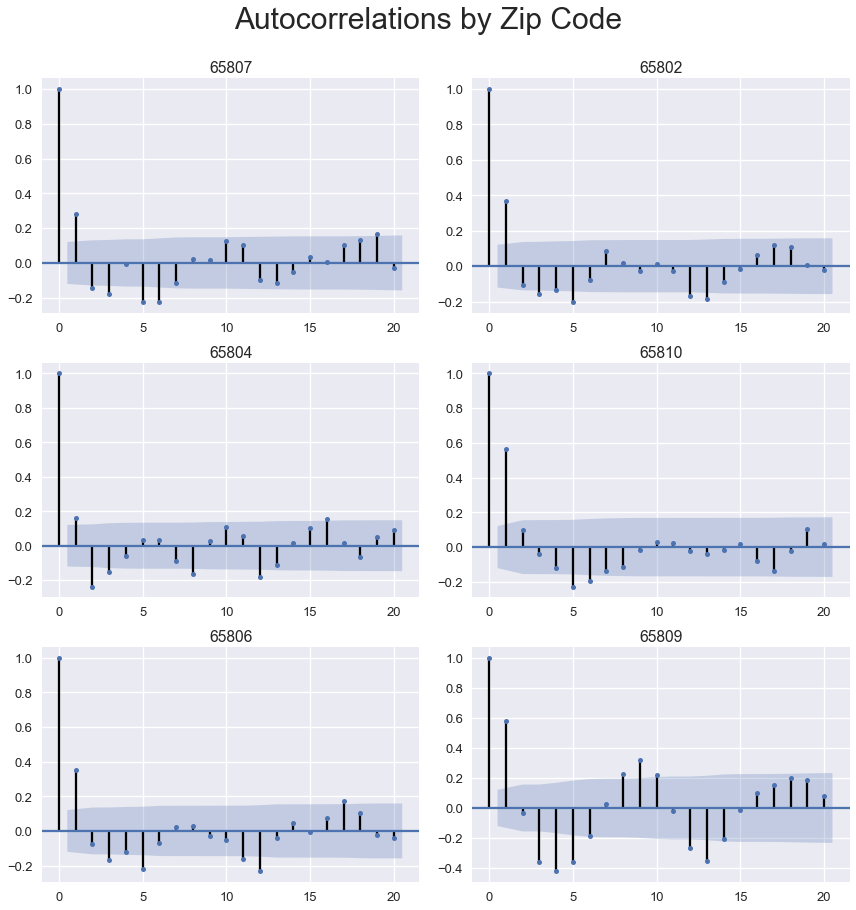

In [5]:
n = len(springfield_diff_2.columns)
fig, axs = plt.subplots(int(np.ceil(n/2)), 2, figsize=(12, 12))
fig.suptitle('Autocorrelations by Zip Code', y=1.05, fontsize=30)
axs_flat = axs.flatten()

for i, col in enumerate(springfield_diff_2.columns):
    plot_acf(springfield_diff_2[col], ax=axs_flat[i], lags=20, title=col)

plt.tight_layout()
plt.savefig('visualizations/autocorrelations-diff_2.png')
plt.show()

### PACF

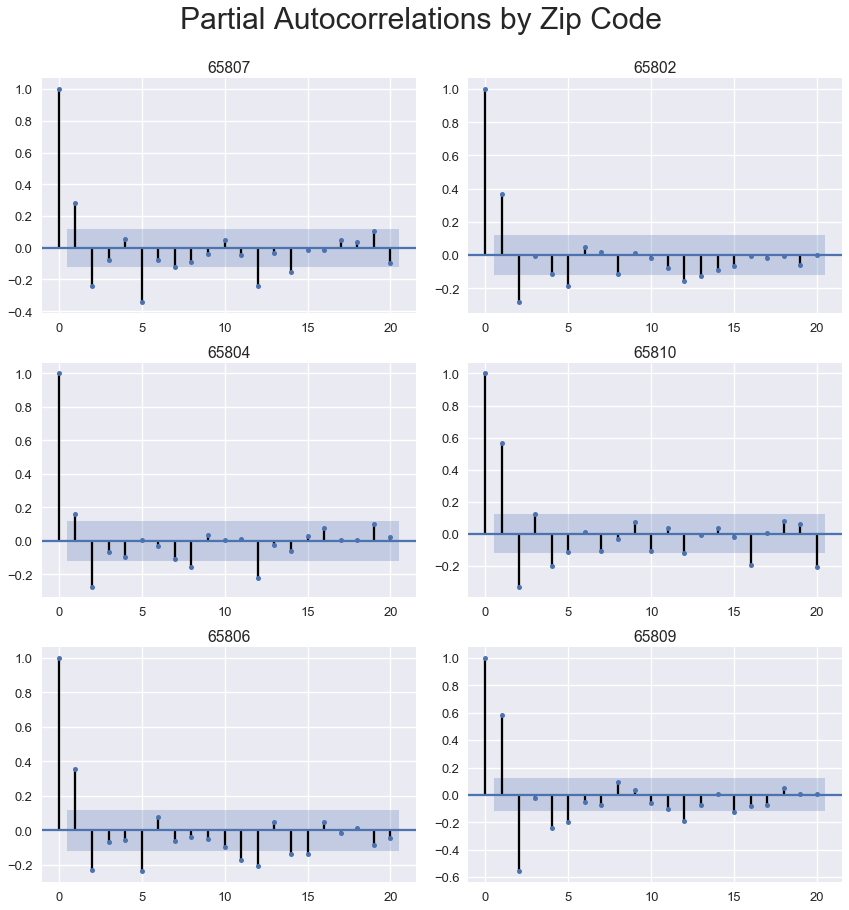

In [6]:
n = len(springfield_diff_2.columns)
fig, axs = plt.subplots(int(np.ceil(n/2)), 2, figsize=(12, 12))
fig.suptitle('Partial Autocorrelations by Zip Code', y=1.05, fontsize=30)
axs_flat = axs.flatten()

for i, col in enumerate(springfield_diff_2.columns):
    plot_pacf(springfield_diff_2[col], ax=axs_flat[i], lags=20, title=col)

plt.tight_layout()
plt.savefig('visualizations/partial-autocorrelations-diff_2.png')
plt.show()

### Model

> order is (p,q) p is determined by the AR (pacf), q is determined by the MA (acf)

In [59]:
len(trainpreds), len(sf_diff_train), len(testpreds), len(sf_diff_test)

(221, 220, 43, 43)

In [60]:
trainpreds

array([ 0.00000000e+00,  8.46381990e+00,  1.35890763e+02,  6.93618479e+01,
        6.93618479e+01,  2.83293231e+00, -1.96753814e+02, -1.96753814e+02,
        1.35890763e+02,  6.93618479e+01,  2.02419679e+02,  1.35890763e+02,
        2.68948595e+02,  1.35890763e+02,  2.02419679e+02,  2.68948595e+02,
        1.35890763e+02,  2.83293231e+00, -1.30224899e+02, -1.96753814e+02,
        6.93618479e+01,  2.83293231e+00,  1.35890763e+02,  6.93618479e+01,
        1.35890763e+02, -6.36959832e+01,  6.93618479e+01,  2.83293231e+00,
        2.83293231e+00, -2.63282730e+02, -3.29811645e+02, -3.96340561e+02,
       -2.63282730e+02,  6.93618479e+01,  6.93618479e+01,  6.93618479e+01,
        6.93618479e+01,  1.35890763e+02,  1.35890763e+02,  6.93618479e+01,
        2.83293231e+00, -2.63282730e+02, -2.63282730e+02, -3.96340561e+02,
       -1.96753814e+02,  6.93618479e+01,  6.93618479e+01,  2.02419679e+02,
        6.93618479e+01,  2.02419679e+02,  2.02419679e+02,  1.35890763e+02,
        1.35890763e+02, -

In [73]:
xy

array([[ 0.0488135 ,  0.21518937],
       [ 0.15157688,  0.26007255],
       [ 0.07523168,  0.40596666],
       [ 0.01281889,  0.79773966],
       [ 0.47648165,  0.68118118],
       [ 0.76820669,  0.7100761 ],
       [ 0.83625125,  1.13567274],
       [ 0.40728731,  0.72280204],
       [-0.07249429,  1.05542189],
       [ 0.20566246,  1.42543403]])

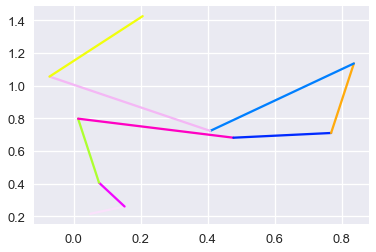

In [72]:
import numpy as np
import matplotlib.pyplot as plt

def uniqueish_color():
    """There're better ways to generate unique colors, but this isn't awful."""
    return plt.cm.gist_ncar(np.random.random())

np.random.seed(0)

xy = (np.random.random((10, 2)) - 0.5).cumsum(axis=0)

fig, ax = plt.subplots()
for start, stop in zip(xy[:-1], xy[1:]):
    x, y = zip(start, stop)
    ax.plot(x, y, color=uniqueish_color())
plt.show()

In [86]:
sf_diff_train

,65807,65802,65804,65810,65806,65809
date,,,,,,
1996-06-01,100.0,100.0,100.0,200.0,0.0,200.0
1996-07-01,100.0,100.0,100.0,200.0,100.0,100.0
1996-08-01,100.0,100.0,0.0,300.0,-200.0,100.0
1996-09-01,200.0,200.0,300.0,300.0,100.0,0.0
1996-10-01,0.0,200.0,100.0,400.0,0.0,-300.0
...,...,...,...,...,...,...
2014-05-01,-100.0,100.0,-300.0,-600.0,-500.0,-1500.0
2014-06-01,400.0,-200.0,600.0,500.0,-200.0,-400.0
2014-07-01,0.0,-300.0,0.0,500.0,200.0,1600.0


In [104]:
springfield_diff_2.index[range(0, len(springfield_diff_2.index), 6)]

Index(['1996-06-01', '1996-12-01', '1997-06-01', '1997-12-01', '1998-06-01',
       '1998-12-01', '1999-06-01', '1999-12-01', '2000-06-01', '2000-12-01',
       '2001-06-01', '2001-12-01', '2002-06-01', '2002-12-01', '2003-06-01',
       '2003-12-01', '2004-06-01', '2004-12-01', '2005-06-01', '2005-12-01',
       '2006-06-01', '2006-12-01', '2007-06-01', '2007-12-01', '2008-06-01',
       '2008-12-01', '2009-06-01', '2009-12-01', '2010-06-01', '2010-12-01',
       '2011-06-01', '2011-12-01', '2012-06-01', '2012-12-01', '2013-06-01',
       '2013-12-01', '2014-06-01', '2014-12-01', '2015-06-01', '2015-12-01',
       '2016-06-01', '2016-12-01', '2017-06-01', '2017-12-01'],
      dtype='object', name='date')

In [138]:
pd.to_datetime([date[:7] for date in springfield_diff_2.index])

DatetimeIndex(['1996-06-01', '1996-07-01', '1996-08-01', '1996-09-01',
               '1996-10-01', '1996-11-01', '1996-12-01', '1997-01-01',
               '1997-02-01', '1997-03-01',
               ...
               '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01',
               '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01',
               '2018-03-01', '2018-04-01'],
              dtype='datetime64[ns]', length=263, freq=None)

In [154]:
xlabels = pd.to_datetime([date[2:7] for date in springfield_diff_2.index], format='%y-%m')
xlabels
import matplotlib.gridspec as gridspec

In [183]:
sf_diff_train.columns

Index(['65807', '65802', '65804', '65810', '65806', '65809'], dtype='object')

In [194]:
r,c = 0,-1
c += 1
if c == 3 and r < 1:
    c = 0
    r = 1
    
print([int(r), int(c)])

[0, 0]


In [207]:
df_rmse = pd.DataFrame(index=['train', 'test'], columns=sf_diff_train.columns)
df_rmse.loc['train', '65807'] = 0
df_rmse

,65807,65802,65804,65810,65806,65809
train,0,NaN,NaN,NaN,NaN,NaN
test,NaN,NaN,NaN,NaN,NaN,NaN


,65807,65802,65804,65810,65806,65809
train,187.175,182.949,182.745,302.38,202.903,670.523
test,354.067,286.884,443.861,534.379,344.748,1102.69


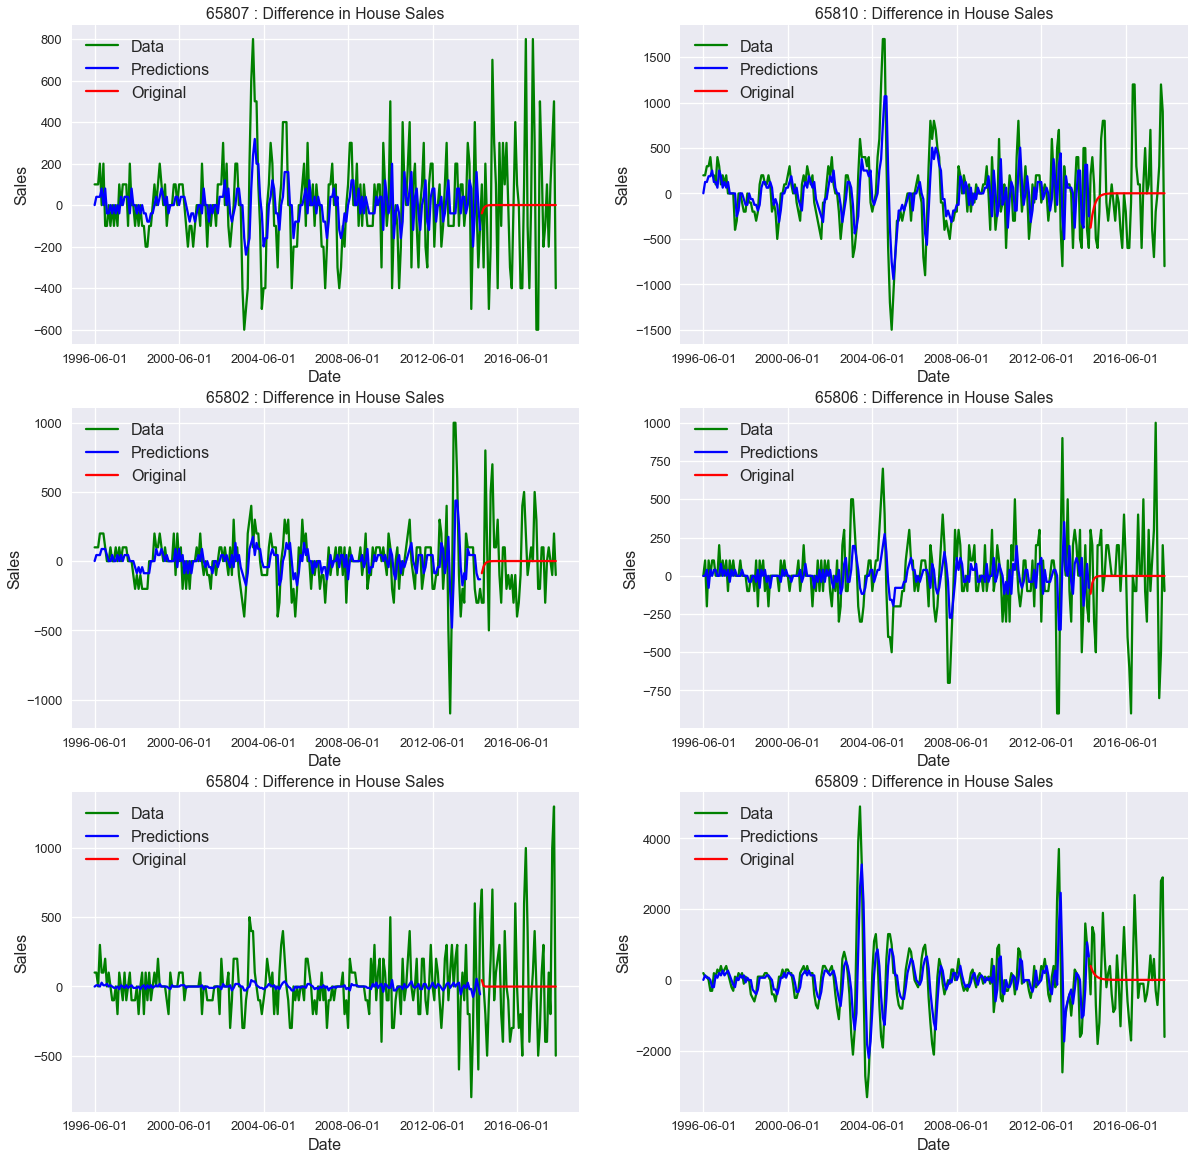

In [216]:
r,c = 0,-1
graphs = {}
count = 0
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(20,20))
df_rmse = pd.DataFrame(index=['train', 'test'], columns=sf_diff_train.columns)

for col in sf_diff_train:
    
    # creating the ARMA Model
    arma = ARMA(sf_diff_train[col], order=(1,0), freq='MS').fit()
    
    trainpreds = pd.DataFrame(np.array(arma.predict()), index=sf_diff_train.index)
    testpreds = pd.DataFrame(arma.forecast(len(sf_diff_test))[0], index=sf_diff_test.index)
#     print(arma.summary())

    c += 1
    
    if c == 3 and r < 1:
        c = 0
        r = 1
        
    ax[int(c), int(r)].plot(springfield_diff_2[col], color='green')
    ax[int(c), int(r)].plot(trainpreds, color ='blue')
    ax[int(c), int(r)].plot(testpreds, color = 'red')

    ax[int(c), int(r)].legend(('Data', 'Predictions', 'Original'), fontsize=16)
    ax[int(c), int(r)].set_title(col + ' : Difference in House Sales')
    ax[int(c), int(r)].set_ylabel('Sales', fontsize=16);
    
    xlabels = np.array([date[:7] for date in springfield_diff_2.index])
    ax[int(c), int(r)].set_xticks(springfield_diff_2.index[range(0, len(springfield_diff_2.index), 48)])
    ax[int(c), int(r)].set_xlabel('Date', fontsize=16);
    
    df_rmse.loc['train', col] = \
    np.sqrt(mean_squared_error(sf_diff_train[col], arma.predict()))
    df_rmse.loc['test', col] = \
    np.sqrt(mean_squared_error(sf_diff_test[col], arma.forecast(len(sf_diff_test))[0]))
    
    
    count += 1
    
df_rmse

                              ARMA Model Results                              
Dep. Variable:                  65807   No. Observations:                  220
Model:                     ARMA(1, 0)   Log Likelihood               -1463.280
Method:                       css-mle   S.D. of innovations            187.156
Date:                Thu, 28 Jan 2021   AIC                           2932.560
Time:                        23:05:14   BIC                           2942.741
Sample:                    06-01-1996   HQIC                          2936.671
                         - 09-01-2014                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.4473     20.904      0.021      0.983     -40.524      41.418
ar.L1.65807     0.3982      0.062      6.456      0.000       0.277       0.519
                                    Roots       

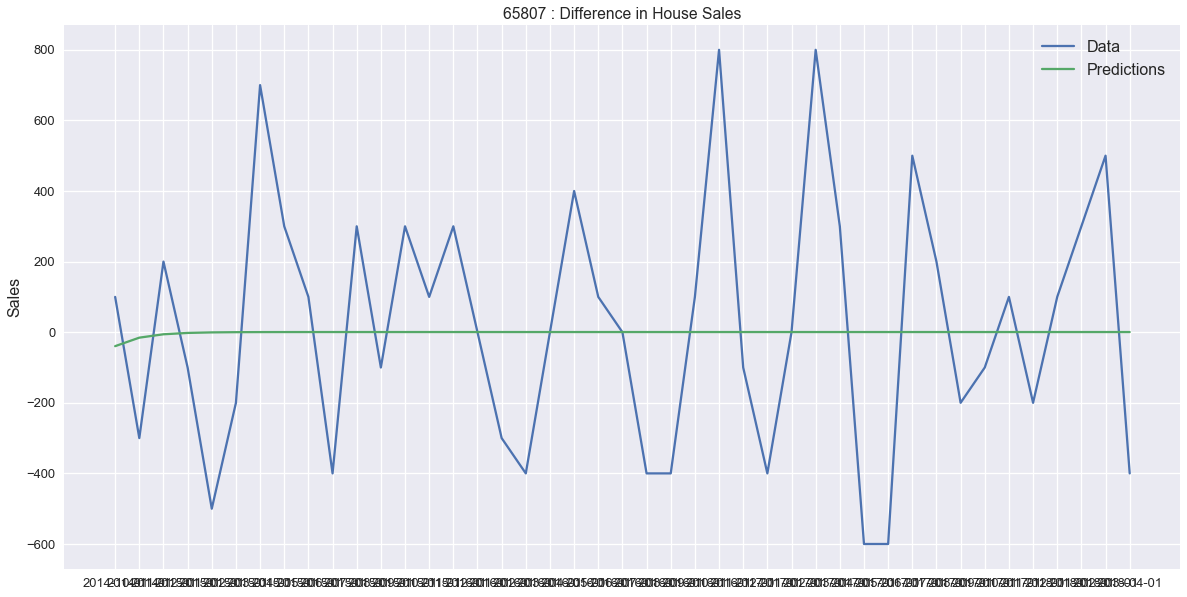

RMSE:  354

 
 

                              ARMA Model Results                              
Dep. Variable:                  65802   No. Observations:                  220
Model:                     ARMA(1, 0)   Log Likelihood               -1458.270
Method:                       css-mle   S.D. of innovations            182.925
Date:                Thu, 28 Jan 2021   AIC                           2922.540
Time:                        23:05:15   BIC                           2932.721
Sample:                    06-01-1996   HQIC                          2926.651
                         - 09-01-2014                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.9989     21.839      0.046      0.964     -41.805      43.803
ar.L1.65802     0.4373      0.061      7.219      0.000       0.319       0.556
                               

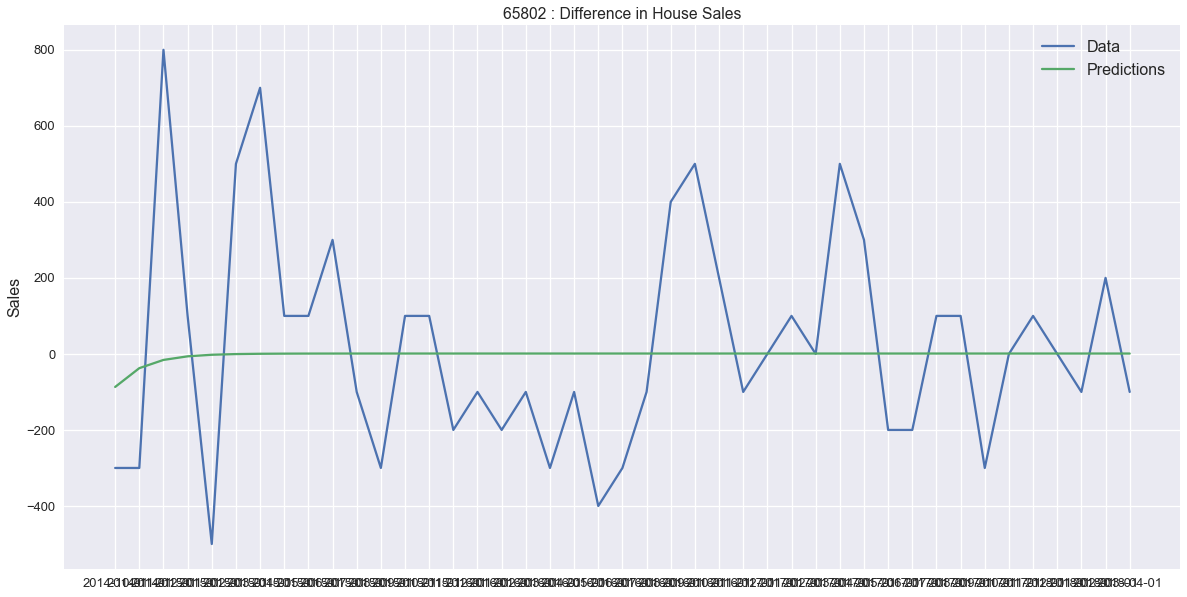

RMSE:  287

 
 

                              ARMA Model Results                              
Dep. Variable:                  65804   No. Observations:                  220
Model:                     ARMA(1, 0)   Log Likelihood               -1457.950
Method:                       css-mle   S.D. of innovations            182.744
Date:                Thu, 28 Jan 2021   AIC                           2921.900
Time:                        23:05:16   BIC                           2932.081
Sample:                    06-01-1996   HQIC                          2926.012
                         - 09-01-2014                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -1.0792     13.582     -0.079      0.937     -27.699      25.540
ar.L1.65804     0.0931      0.068      1.366      0.172      -0.041       0.227
                               

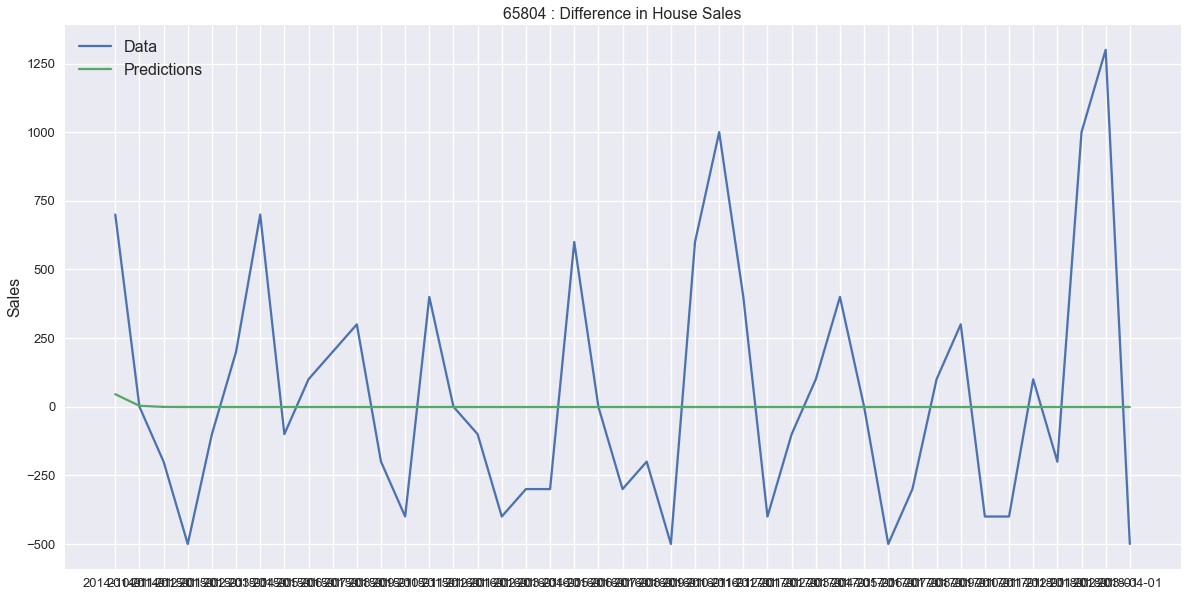

RMSE:  444

 
 

                              ARMA Model Results                              
Dep. Variable:                  65810   No. Observations:                  220
Model:                     ARMA(1, 0)   Log Likelihood               -1568.904
Method:                       css-mle   S.D. of innovations            302.264
Date:                Thu, 28 Jan 2021   AIC                           3143.809
Time:                        23:05:17   BIC                           3153.990
Sample:                    06-01-1996   HQIC                          3147.920
                         - 09-01-2014                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.9284     54.543      0.035      0.972    -104.973     108.830
ar.L1.65810     0.6292      0.052     11.985      0.000       0.526       0.732
                               

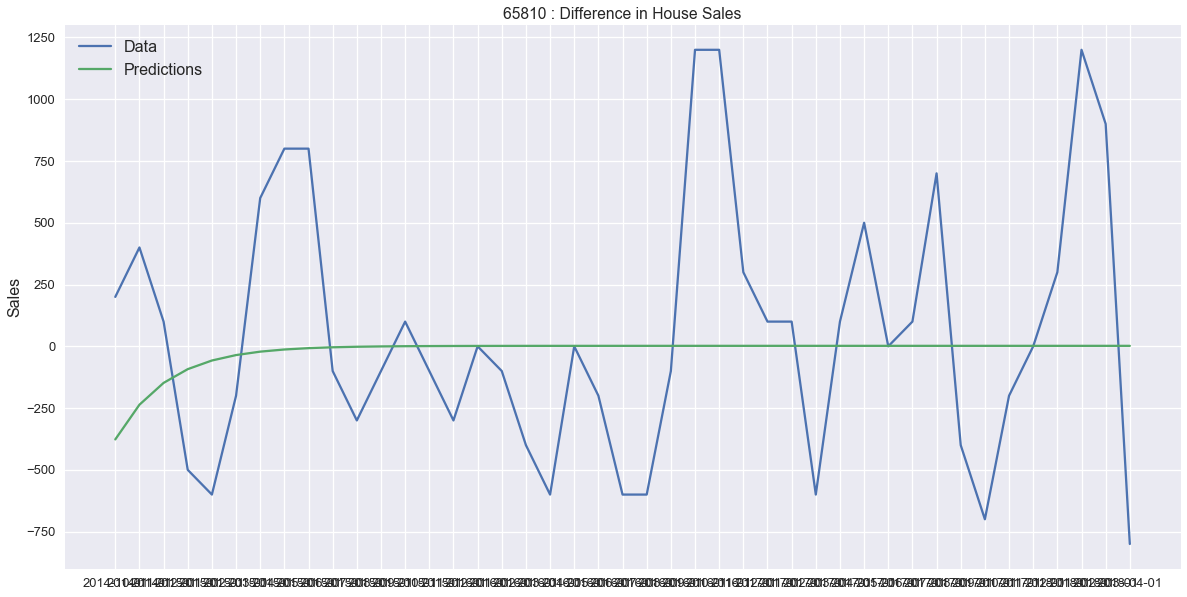

RMSE:  534

 
 

                              ARMA Model Results                              
Dep. Variable:                  65806   No. Observations:                  220
Model:                     ARMA(1, 0)   Log Likelihood               -1481.049
Method:                       css-mle   S.D. of innovations            202.903
Date:                Thu, 28 Jan 2021   AIC                           2968.098
Time:                        23:05:18   BIC                           2978.279
Sample:                    06-01-1996   HQIC                          2972.209
                         - 09-01-2014                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -1.3249     22.387     -0.059      0.953     -45.202      42.552
ar.L1.65806     0.3907      0.062      6.288      0.000       0.269       0.512
                               

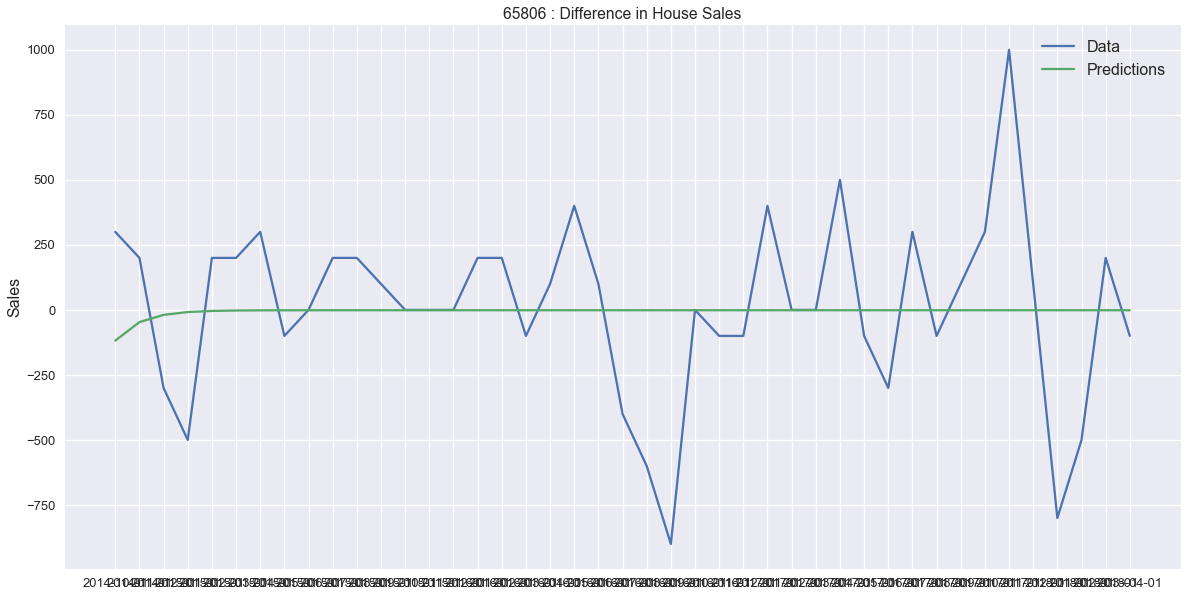

RMSE:  345

 
 

                              ARMA Model Results                              
Dep. Variable:                  65809   No. Observations:                  220
Model:                     ARMA(1, 0)   Log Likelihood               -1744.213
Method:                       css-mle   S.D. of innovations            670.468
Date:                Thu, 28 Jan 2021   AIC                           3494.427
Time:                        23:05:19   BIC                           3504.608
Sample:                    06-01-1996   HQIC                          3498.538
                         - 09-01-2014                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           8.4638    133.856      0.063      0.950    -253.889     270.817
ar.L1.65809     0.6653      0.050     13.315      0.000       0.567       0.763
                               

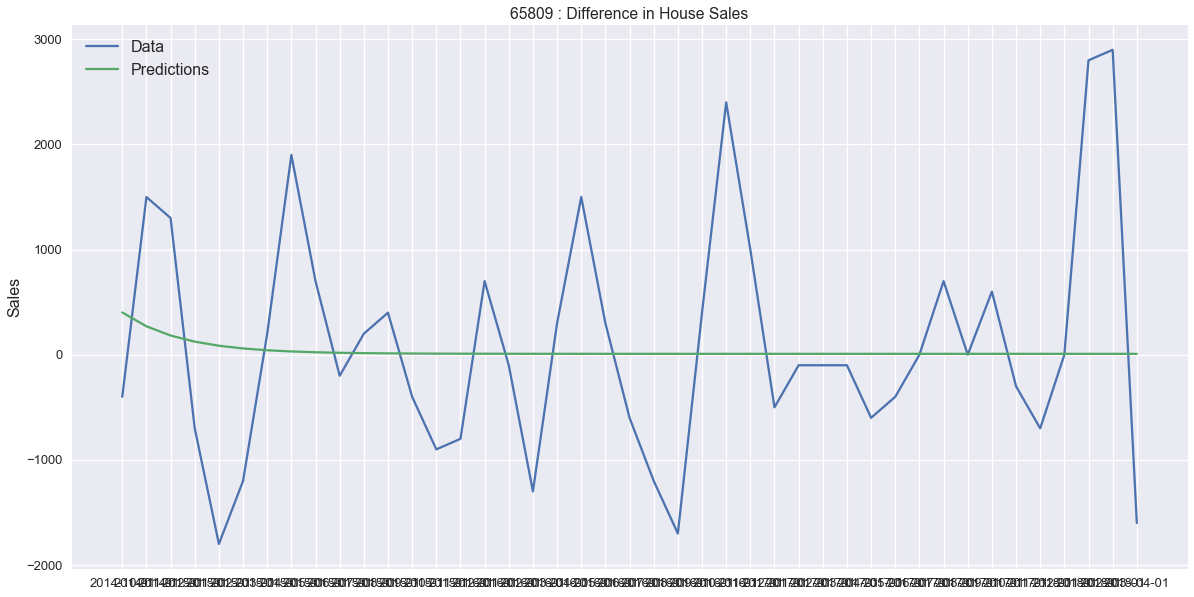

RMSE:  1103

 
 



In [47]:
for col in sf_diff_train:
    
    #creating the ARMA Model
    arma = ARMA(sf_diff_train[col], order=(1,0), freq='MS').fit()
    print(arma.summary())
    
    arma_forecast = arma.forecast(steps=len(sf_diff_test[col]))[0]
    RMSE = np.sqrt(mean_squared_error(sf_diff_test[col], arma_forecast))
    
    # plotting forecast vs actual
    plt.figure(figsize=(20,10))

    plt.plot(sf_diff_test[col])
    plt.plot(arma_forecast)

    plt.legend(('Data', 'Predictions'), fontsize=16)
    plt.title(col + ' : Difference in House Sales')
    plt.ylabel('Sales', fontsize=16);
    
#     xlabels = [sf_diff_test.index[test_intervals]]
#     plt.xticks(sf_diff_test.index, xlabels)
    
    plt.show()

    print('RMSE: ', round(RMSE))
    print('\n \n \n')

## ARIMA

### model

                             ARIMA Model Results                              
Dep. Variable:               D2.65807   No. Observations:                  218
Model:                 ARIMA(1, 2, 0)   Log Likelihood               -1449.680
Method:                       css-mle   S.D. of innovations            186.900
Date:                Thu, 28 Jan 2021   AIC                           2905.361
Time:                        22:01:36   BIC                           2915.514
Sample:                    06-01-1996   HQIC                          2909.462
                         - 07-01-2014                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              2.5787     20.990      0.123      0.902     -38.562      43.719
ar.L1.D2.65807     0.3988      0.062      6.442      0.000       0.277       0.520
                                    

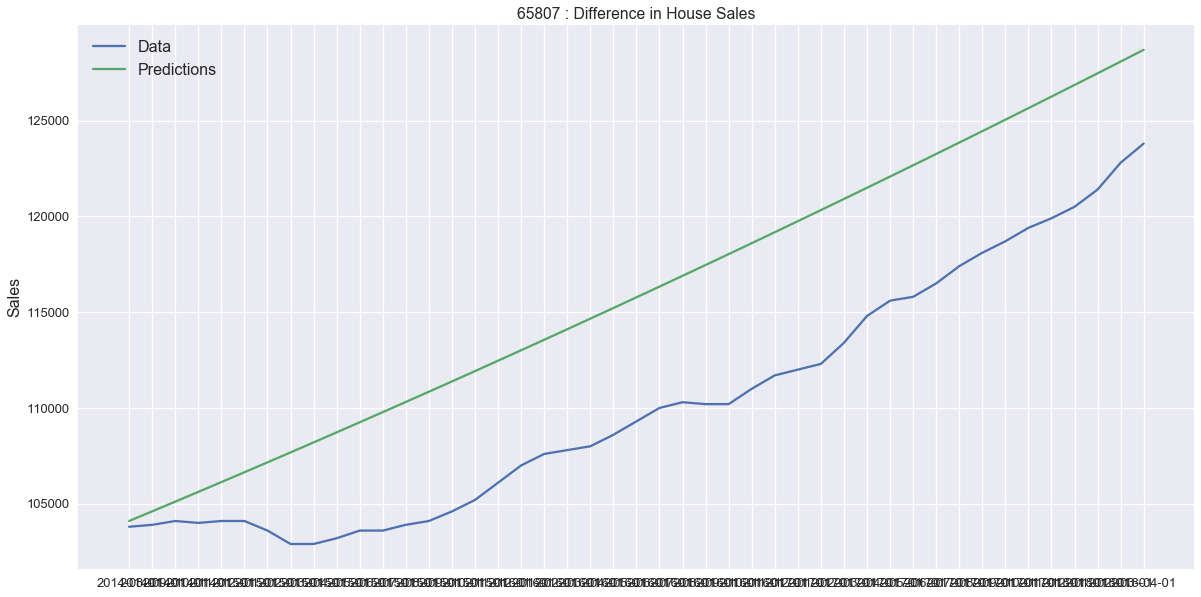

RMSE: 6039 
 
 

                             ARIMA Model Results                              
Dep. Variable:               D2.65802   No. Observations:                  218
Model:                 ARIMA(1, 2, 0)   Log Likelihood               -1445.499
Method:                       css-mle   S.D. of innovations            183.337
Date:                Thu, 28 Jan 2021   AIC                           2896.999
Time:                        22:01:37   BIC                           2907.152
Sample:                    06-01-1996   HQIC                          2901.100
                         - 07-01-2014                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              2.9623     21.677      0.137      0.891     -39.524      45.449
ar.L1.D2.65802     0.4291      0.061      6.997      0.000       0.309       0.549
                   

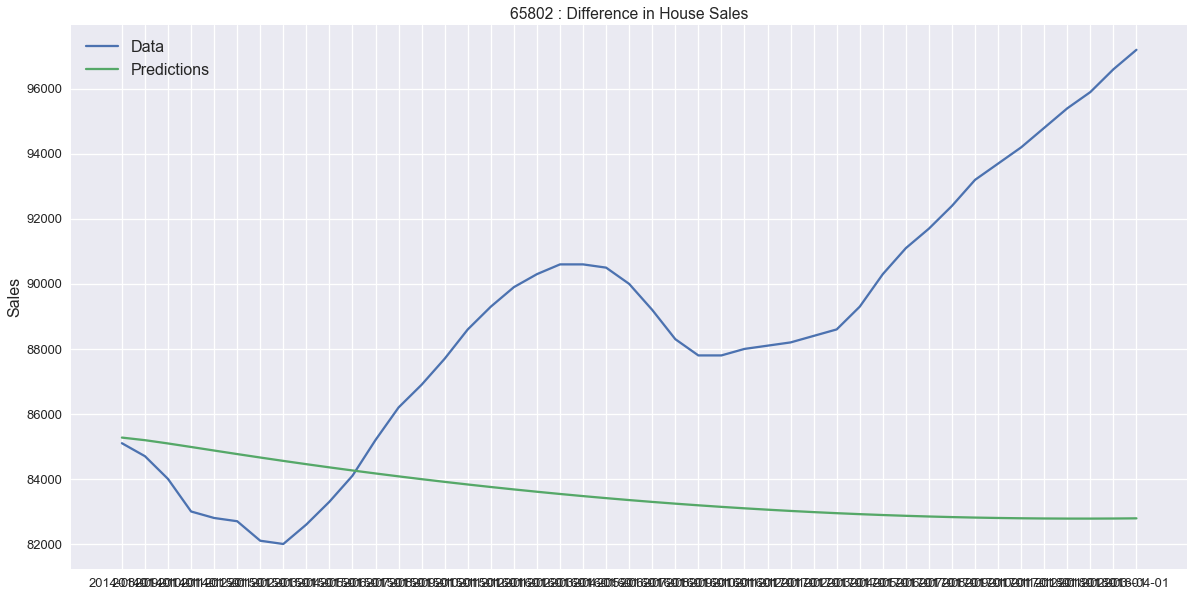

RMSE: 6989 
 
 

                             ARIMA Model Results                              
Dep. Variable:               D2.65804   No. Observations:                  218
Model:                 ARIMA(1, 2, 0)   Log Likelihood               -1435.018
Method:                       css-mle   S.D. of innovations            174.804
Date:                Thu, 28 Jan 2021   AIC                           2876.036
Time:                        22:01:38   BIC                           2886.190
Sample:                    06-01-1996   HQIC                          2880.137
                         - 07-01-2014                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.8400     13.791     -0.061      0.951     -27.870      26.190
ar.L1.D2.65804     0.1422      0.067      2.124      0.034       0.011       0.273
                   

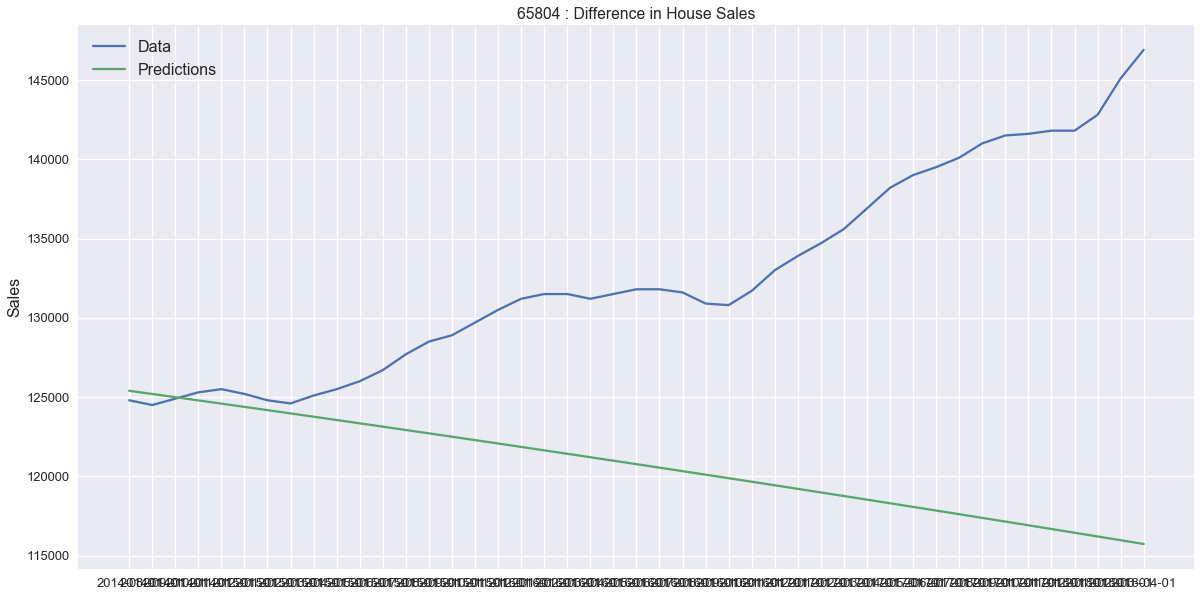

RMSE: 15010 
 
 

                             ARIMA Model Results                              
Dep. Variable:               D2.65810   No. Observations:                  218
Model:                 ARIMA(1, 2, 0)   Log Likelihood               -1552.112
Method:                       css-mle   S.D. of innovations            298.764
Date:                Thu, 28 Jan 2021   AIC                           3110.225
Time:                        22:01:39   BIC                           3120.378
Sample:                    06-01-1996   HQIC                          3114.326
                         - 07-01-2014                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             14.9844     55.119      0.272      0.786     -93.047     123.016
ar.L1.D2.65810     0.6357      0.052     12.176      0.000       0.533       0.738
                  

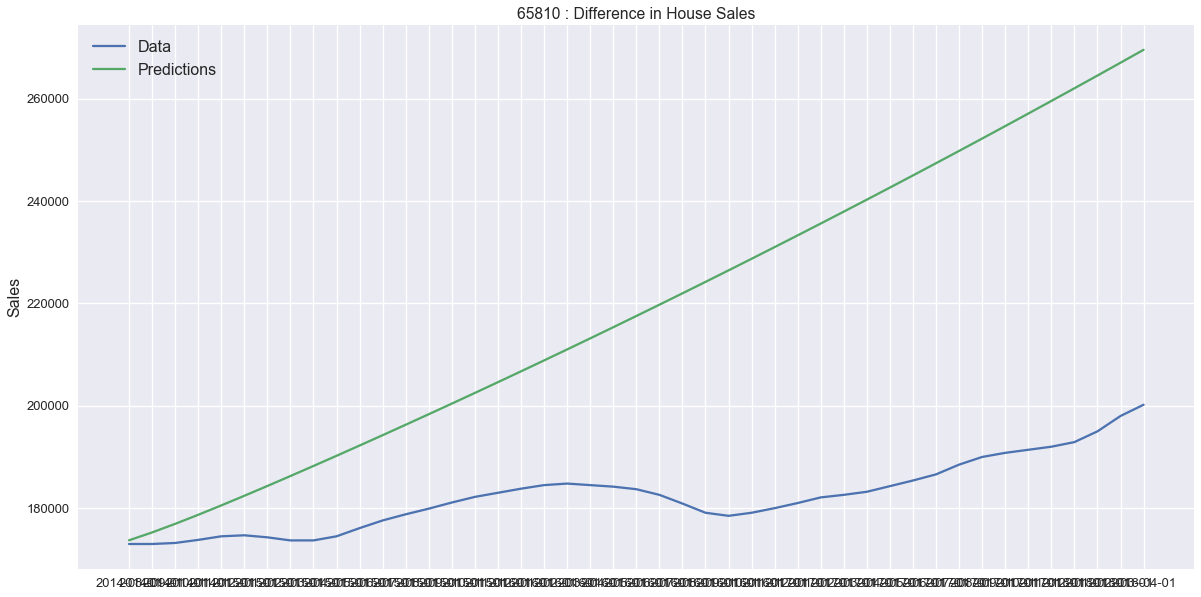

RMSE: 42890 
 
 

                             ARIMA Model Results                              
Dep. Variable:               D2.65806   No. Observations:                  218
Model:                 ARIMA(1, 2, 0)   Log Likelihood               -1467.043
Method:                       css-mle   S.D. of innovations            202.398
Date:                Thu, 28 Jan 2021   AIC                           2940.086
Time:                        22:01:40   BIC                           2950.239
Sample:                    06-01-1996   HQIC                          2944.187
                         - 07-01-2014                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              2.4109     22.470      0.107      0.915     -41.629      46.450
ar.L1.D2.65806     0.3917      0.062      6.297      0.000       0.270       0.514
                  

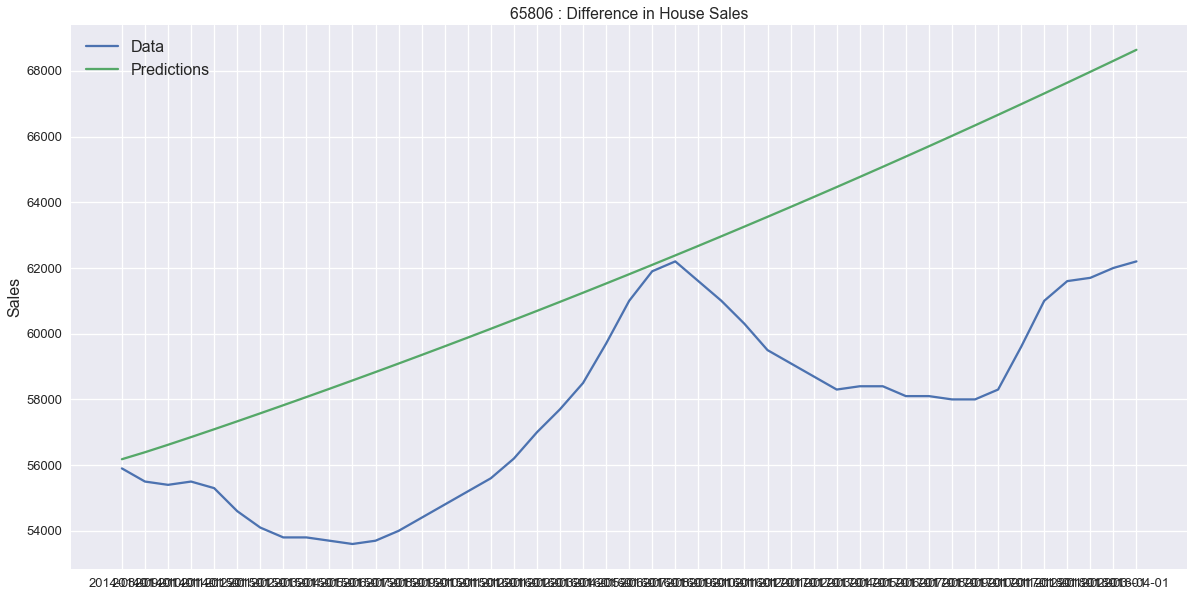

RMSE: 4889 
 
 

                             ARIMA Model Results                              
Dep. Variable:               D2.65809   No. Observations:                  218
Model:                 ARIMA(1, 2, 0)   Log Likelihood               -1729.345
Method:                       css-mle   S.D. of innovations            673.501
Date:                Thu, 28 Jan 2021   AIC                           3464.689
Time:                        22:01:41   BIC                           3474.843
Sample:                    06-01-1996   HQIC                          3468.790
                         - 07-01-2014                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             10.2561    135.496      0.076      0.940    -255.310     275.823
ar.L1.D2.65809     0.6663      0.051     13.143      0.000       0.567       0.766
                   

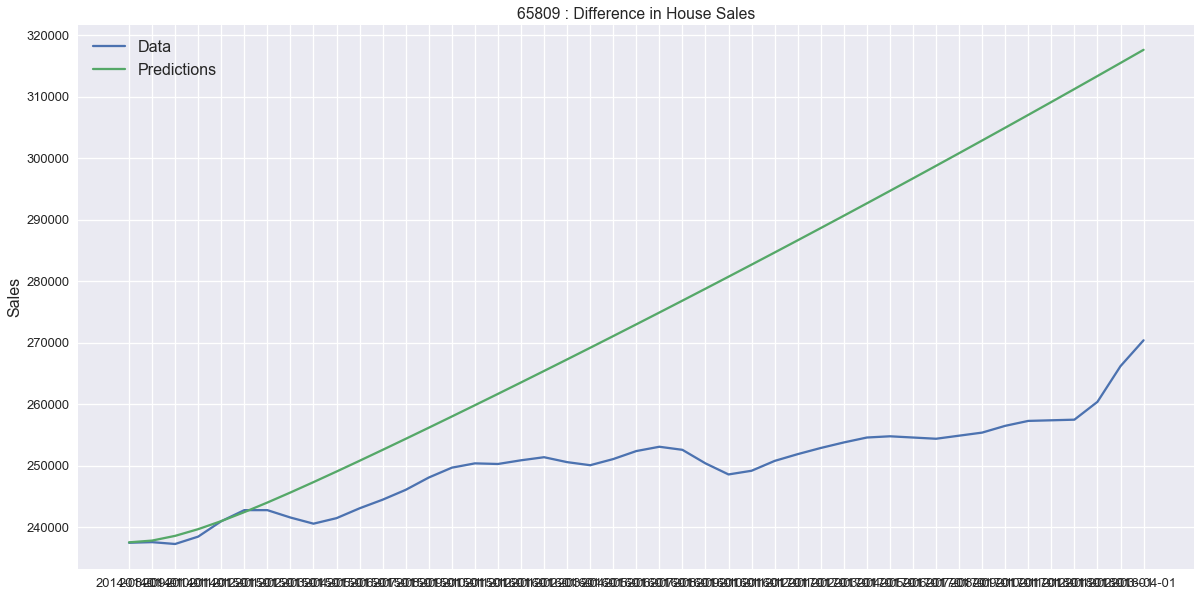

RMSE: 29993 
 
 



In [8]:
for col in sf_train:
    # model
    arima = ARIMA(sf_train[col], order= (1,2,0), freq='MS').fit()
    print(arima.summary())
    
    # forecast
    arima_forecast = arima.forecast(steps=len(sf_test))[0]
    
    # plotting forecast vs actual
    plt.figure(figsize=(20,10))

    plt.plot(sf_test[col])
    plt.plot(arima_forecast)

    plt.legend(('Data', 'Predictions'), fontsize=16)
    plt.title(col + ' : Difference in House Sales')
    plt.ylabel('Sales', fontsize=16);
    
    plt.show()

    #RMSE
    RMSE = np.sqrt(mean_squared_error(sf_test[col], arima_forecast))
    print('RMSE:', round(RMSE), '\n \n \n')

## Auto-ARIMA

In [9]:
!pip install pmdarima

In [10]:
from pmdarima.arima import auto_arima

In [11]:
order_dict = {}

In [12]:
for col in sf_train:
    auto = auto_arima(sf_train[col], max_order=None, max_p=10, max_q=10, max_d=5, information_criterion='aic')
    
    order_dict[col] = auto.get_params()['order']
    
    print(col)
    print(auto.summary(), '\n\n\n')

65807
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  220
Model:               SARIMAX(2, 2, 2)   Log Likelihood               -1446.488
Date:                Thu, 28 Jan 2021   AIC                           2902.977
Time:                        22:01:49   BIC                           2919.899
Sample:                             0   HQIC                          2909.812
                                - 220                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4201      0.065     21.828      0.000       1.293       1.548
ar.L2         -0.8737      0.054    -16.073      0.000      -0.980      -0.767
ma.L1         -1.2821      0.077    -16.666   

65809
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  220
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -1942.773
Date:                Thu, 28 Jan 2021   AIC                           3891.546
Time:                        22:02:06   BIC                           3901.713
Sample:                             0   HQIC                          3895.652
                                - 220                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    266.7573    125.204      2.131      0.033      21.362     512.152
ma.L1          0.0345      0.006      6.088      0.000       0.023       0.046
sigma2      2.955e+06      0.063   4.66e+07   

In [13]:
order_dict

{'65807': (2, 2, 2),
 '65802': (3, 1, 1),
 '65804': (2, 2, 2),
 '65810': (1, 1, 1),
 '65806': (3, 1, 2),
 '65809': (0, 1, 1)}

## ARIMA (Final)

                             ARIMA Model Results                              
Dep. Variable:               D2.65807   No. Observations:                  218
Model:                 ARIMA(2, 2, 2)   Log Likelihood               -1433.957
Method:                       css-mle   S.D. of innovations            173.579
Date:                Thu, 28 Jan 2021   AIC                           2879.914
Time:                        22:02:06   BIC                           2900.221
Sample:                    06-01-1996   HQIC                          2888.116
                         - 07-01-2014                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.1920      5.692      0.034      0.973     -10.963      11.347
ar.L1.D2.65807     1.5038      0.083     18.189      0.000       1.342       1.666
ar.L2.D2.65807    -0.7217      0.083

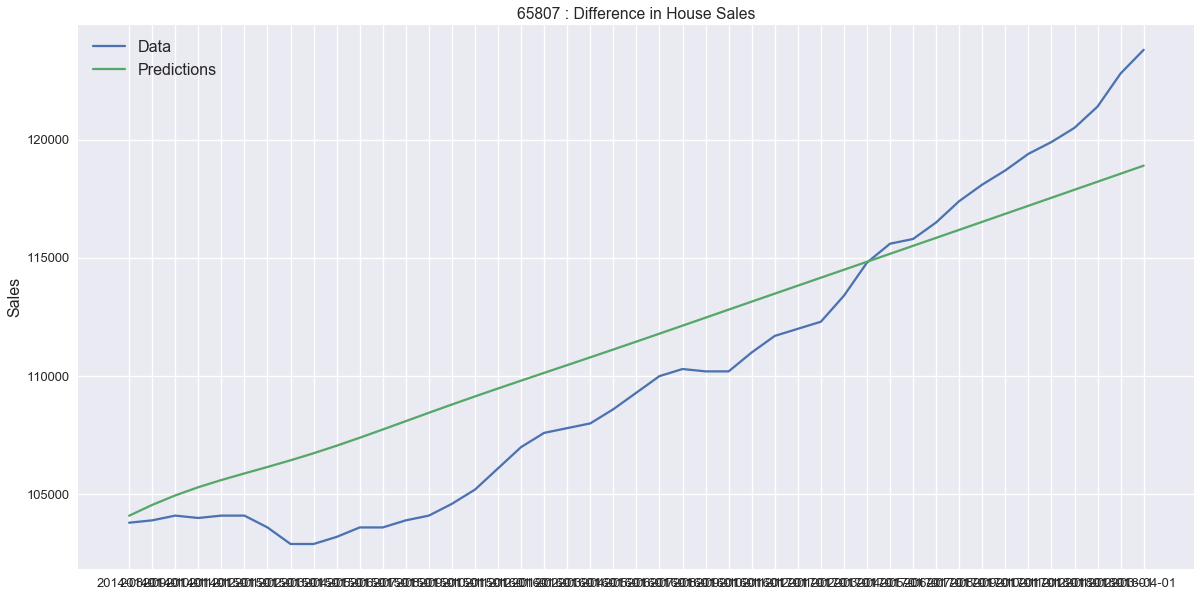

RMSE: 2674 
 
 

                             ARIMA Model Results                              
Dep. Variable:                D.65802   No. Observations:                  219
Model:                 ARIMA(3, 1, 1)   Log Likelihood               -1431.822
Method:                       css-mle   S.D. of innovations            166.269
Date:                Thu, 28 Jan 2021   AIC                           2875.643
Time:                        22:02:07   BIC                           2895.978
Sample:                    05-01-1996   HQIC                          2883.856
                         - 07-01-2014                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            72.7292    103.896      0.700      0.484    -130.904     276.362
ar.L1.D.65802     1.8898      0.198      9.559      0.000       1.502       2.277
ar.L2.D.65802    -1.365

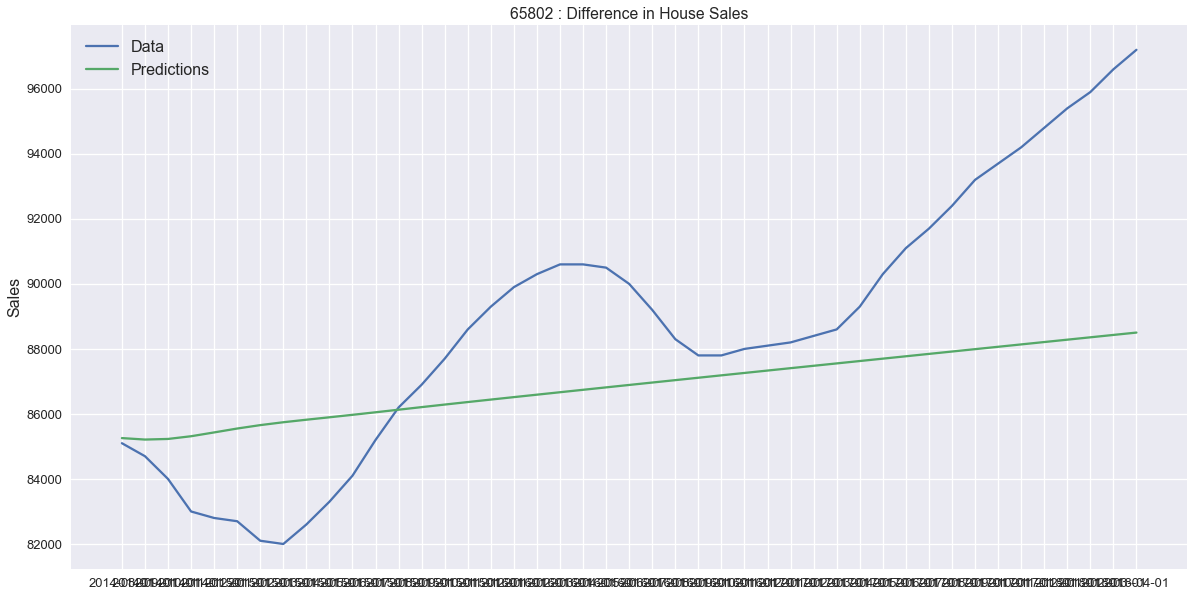

RMSE: 3713 
 
 

                             ARIMA Model Results                              
Dep. Variable:               D2.65804   No. Observations:                  218
Model:                 ARIMA(2, 2, 2)   Log Likelihood               -1429.580
Method:                       css-mle   S.D. of innovations            169.448
Date:                Thu, 28 Jan 2021   AIC                           2871.160
Time:                        22:02:08   BIC                           2891.467
Sample:                    06-01-1996   HQIC                          2879.362
                         - 07-01-2014                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -2.4155      1.671     -1.446      0.148      -5.690       0.859
ar.L1.D2.65804     0.9434      0.402      2.349      0.019       0.156       1.730
ar.L2.D2.65804    -

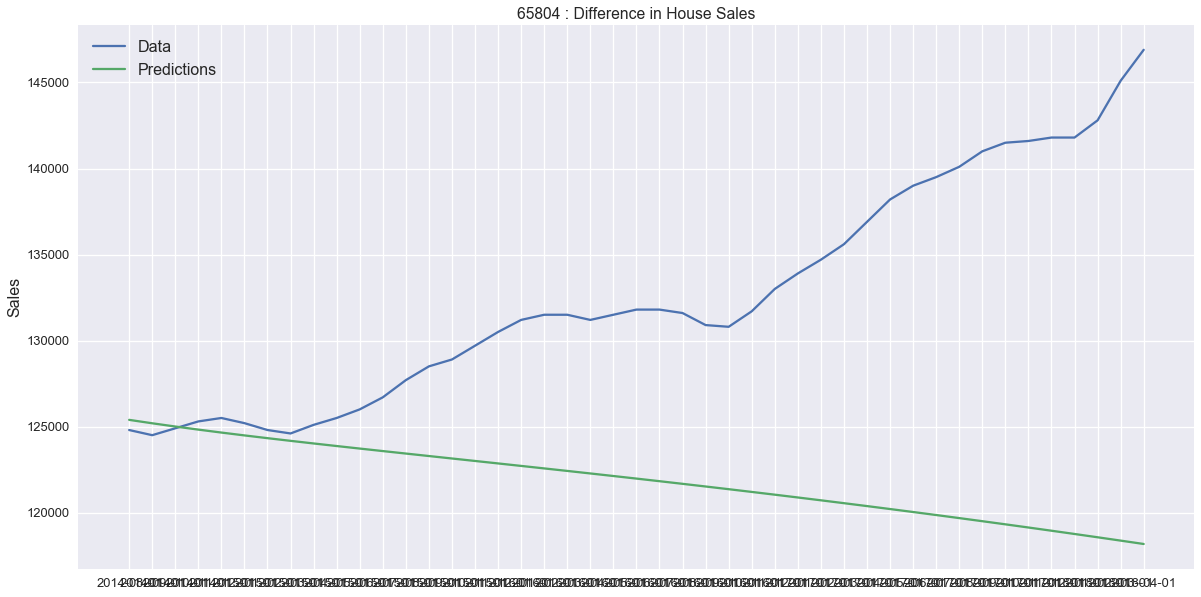

RMSE: 13597 
 
 

                             ARIMA Model Results                              
Dep. Variable:                D.65810   No. Observations:                  219
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1552.367
Method:                       css-mle   S.D. of innovations            287.641
Date:                Thu, 28 Jan 2021   AIC                           3112.734
Time:                        22:02:09   BIC                           3126.291
Sample:                    05-01-1996   HQIC                          3118.209
                         - 07-01-2014                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           221.4057    343.795      0.644      0.520    -452.419     895.231
ar.L1.D.65810     0.9079      0.028     32.245      0.000       0.853       0.963
ma.L1.D.65810     0.70

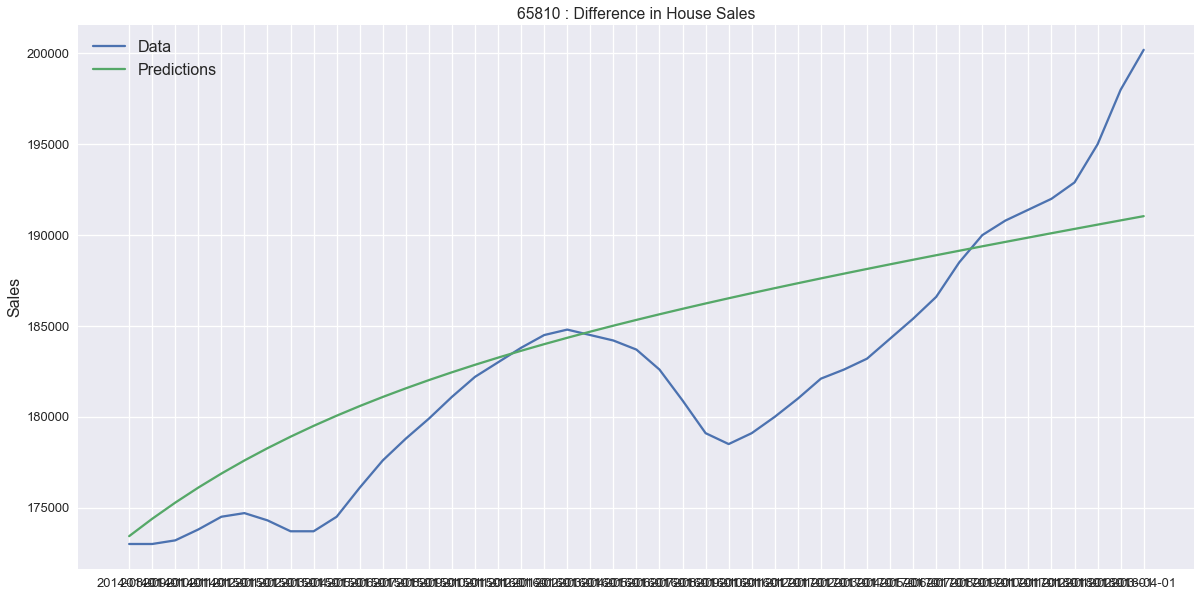

RMSE: 4134 
 
 

                             ARIMA Model Results                              
Dep. Variable:                D.65806   No. Observations:                  219
Model:                 ARIMA(3, 1, 2)   Log Likelihood               -1451.972
Method:                       css-mle   S.D. of innovations            182.149
Date:                Thu, 28 Jan 2021   AIC                           2917.944
Time:                        22:02:10   BIC                           2941.667
Sample:                    05-01-1996   HQIC                          2927.525
                         - 07-01-2014                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            78.5400     98.283      0.799      0.424    -114.091     271.171
ar.L1.D.65806     0.1261      0.149      0.846      0.397      -0.166       0.418
ar.L2.D.65806     0.517

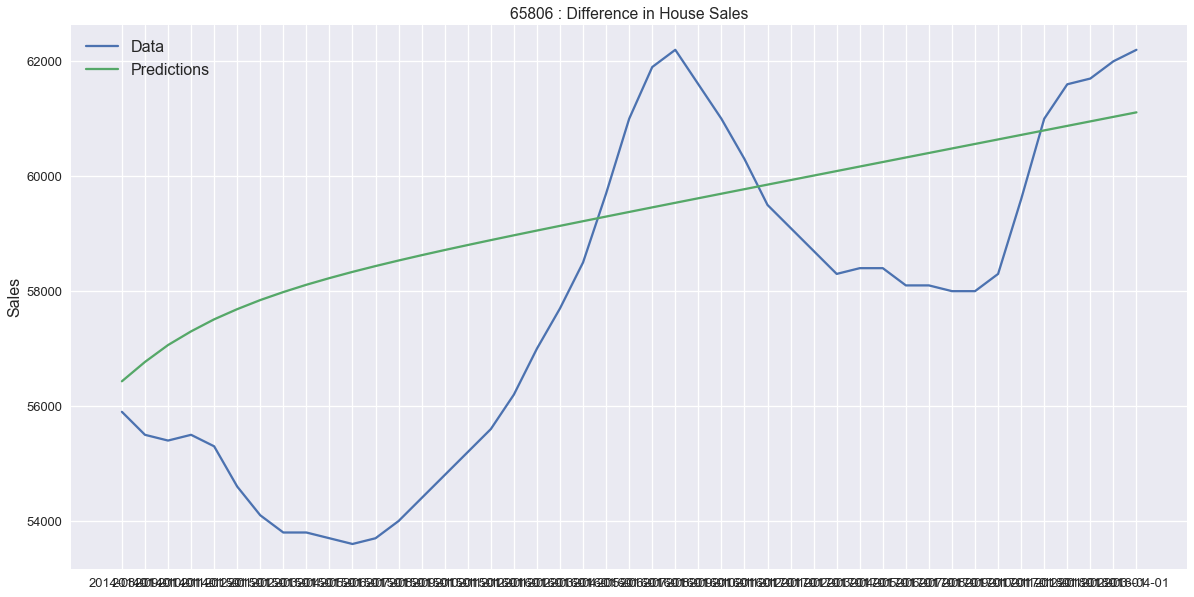

RMSE: 2568 
 
 

                             ARIMA Model Results                              
Dep. Variable:                D.65809   No. Observations:                  219
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -1816.712
Method:                       css-mle   S.D. of innovations            964.205
Date:                Thu, 28 Jan 2021   AIC                           3639.424
Time:                        22:02:12   BIC                           3649.591
Sample:                    05-01-1996   HQIC                          3643.530
                         - 07-01-2014                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           361.6633    126.668      2.855      0.004     113.399     609.928
ma.L1.D.65809     0.9484      0.021     46.100      0.000       0.908       0.989
                       

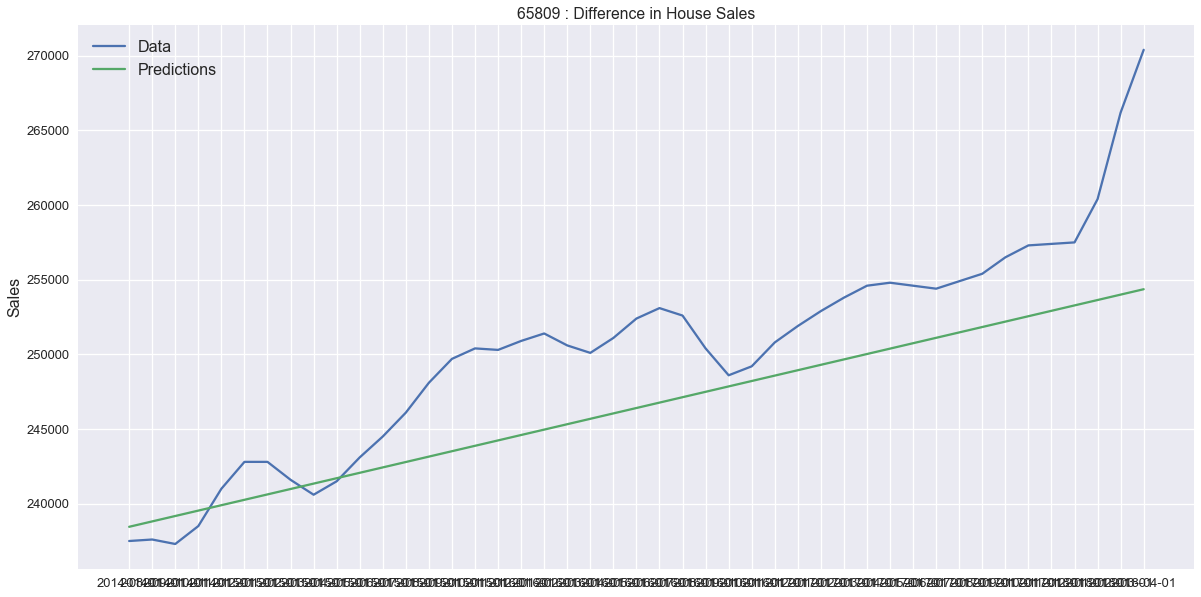

RMSE: 4974 
 
 



In [14]:
for col in sf_train:
    # model
    arima = ARIMA(sf_train[col], order=order_dict[col] , freq='MS').fit()
    print(arima.summary())
    
    # forecast
    arima_forecast = arima.forecast(steps=len(sf_test))[0]
    
    # plotting forecast vs actual
    plt.figure(figsize=(20,10))

    plt.plot(sf_test[col])
    plt.plot(arima_forecast)

    plt.legend(('Data', 'Predictions'), fontsize=16)
    plt.title(col + ' : Difference in House Sales')
    plt.ylabel('Sales', fontsize=16);
    
    plt.show()

    #RMSE
    RMSE = np.sqrt(mean_squared_error(sf_test[col], arima_forecast))
    print('RMSE:', round(RMSE), '\n \n \n')

In [15]:
arima.aic

3639.423795264077

## Facebook Prophet